# Stacked Regressions to predict House Prices 

The metodology use in this notebook is based on the work https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
sns.set_style('whitegrid')
from bokeh.io import output_notebook
output_notebook()
import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
train = pd.read_csv('data/House_price_data/train.csv')
test = pd.read_csv('data/House_price_data/test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.shape

(1460, 81)

In [6]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
#drop the id column
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

### Missing Data

In [9]:
from mltools.featureEngineering import missing_values

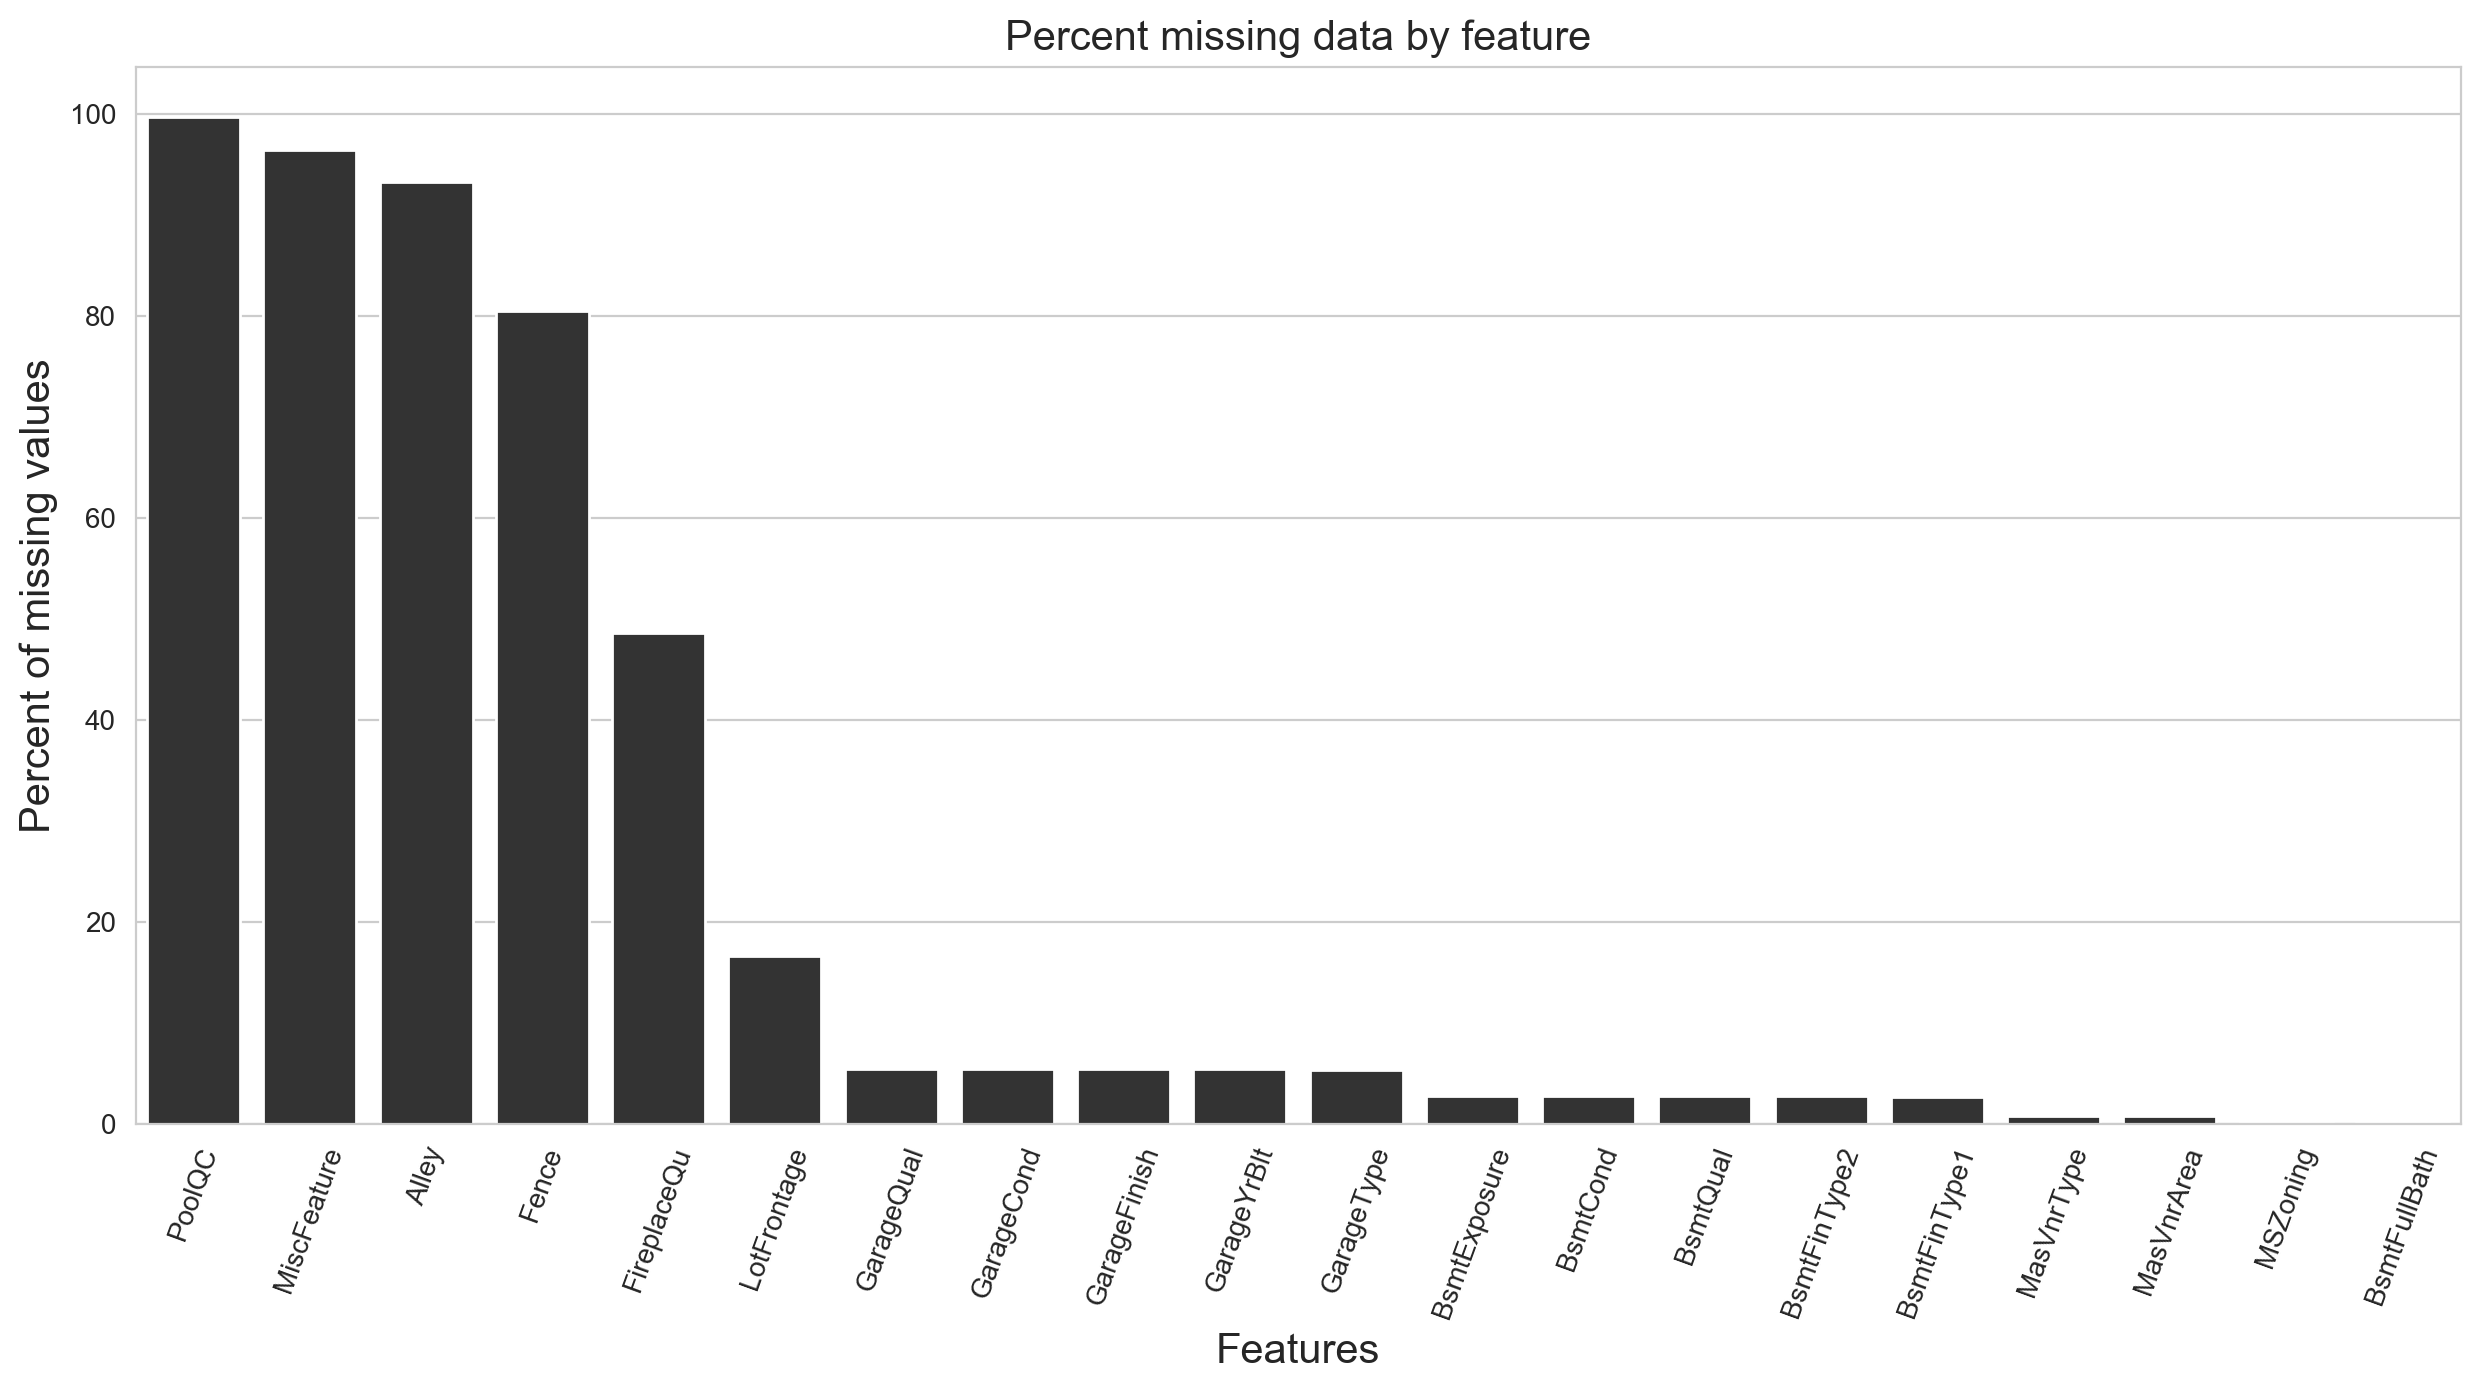

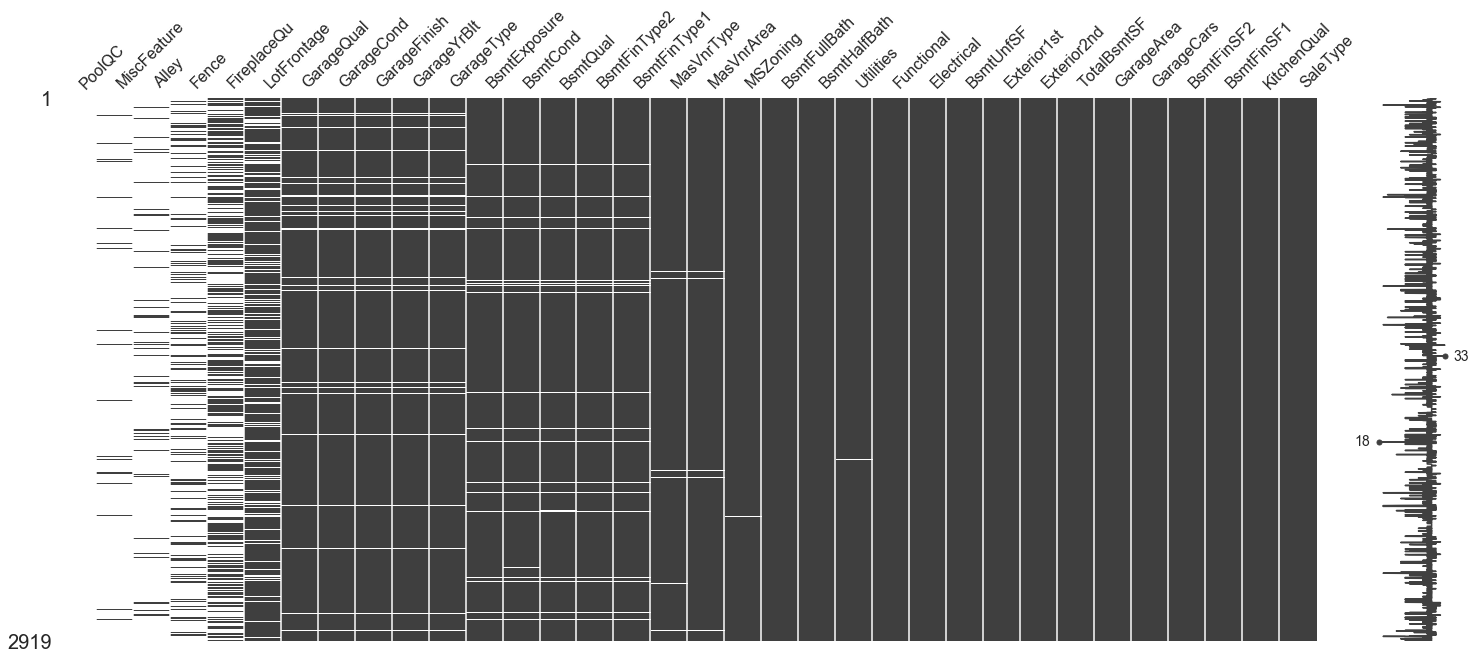

In [10]:
missing_df = missing_values.get_missing_values(all_data, features_lim=20, figsize=(15, 7))

In [11]:
missing_df

,Missing Ratio,Missing count
PoolQC,99.657417,2909
MiscFeature,96.402878,2814
Alley,93.216855,2721
Fence,80.438506,2348
FireplaceQu,48.646797,1420
LotFrontage,16.649538,486
GarageQual,5.447071,159
GarageCond,5.447071,159
GarageFinish,5.447071,159
GarageYrBlt,5.447071,159


### Imputing Missing Values

- **PoolQC** : data description says NA means "No  Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general. 
- **MiscFeature** : data description says NA means "no misc feature"
- **Alley** : data description says NA means "no alley access"
- **Fence** : data description says NA means "no fence"
- **FireplaceQu** : data description says NA means "no fireplace"
- **LotFrontage** : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can **fill in missing values by the median LotFrontage of the neighborhood**.
- **GarageType, GarageFinish, GarageQual and GarageCond** : Replacing missing data with None
- **GarageYrBlt, GarageArea and GarageCars**: 0 (No garage = no cars in such garage).
- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath** : missing values are likely zero for having no basement
- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2** : For all these categorical basement-related features, NaN means that there is no  basement.
- **MasVnrArea and MasVnrType** : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type. 
- **MSZoning (The general zoning classification)** :  'RL' is by far  the most common value.  So we can fill in missing values with 'RL'
- **Utilities** : For this categorical feature all records are "AllPub", except for one "NoSeWa"  and 2 NA . Since the house with 'NoSewa' is in the training set, **this feature won't help in predictive modelling**. We can then safely  remove it.
- **Functional** : data description says NA means typical
- **Electrical** : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
- **KitchenQual, Exterior1st and Exterior2nd, SaleType**: as the previous.
- **MSSubClass** : Na most likely means No building class. We can replace missing values with None

In [12]:
cols = ["PoolQC", "MiscFeature","Alley", "Fence","FireplaceQu",
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
         'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', "MasVnrType", 'MSSubClass']

In [13]:
for col in cols:
    all_data[col] = all_data[col].fillna('None')

In [14]:
cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

In [15]:
for col in cols:
    all_data[col] = all_data[col].fillna(0)

In [16]:
cols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

In [17]:
for col in cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [18]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [19]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [20]:
all_data = all_data.drop(['Utilities'], axis=1)

In [21]:
all_data.isnull().sum().sum()

0

### Features Engeneering

In [22]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [23]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


In [24]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Target variable analysis

In [25]:
from scipy import stats
from scipy.stats import norm, skew

In [26]:
#dividiamo di nuovo tra train e test per analizzare la variabile target
train = all_data[:ntrain]
test = all_data[ntrain:]
train['SalePrice'] = y_train

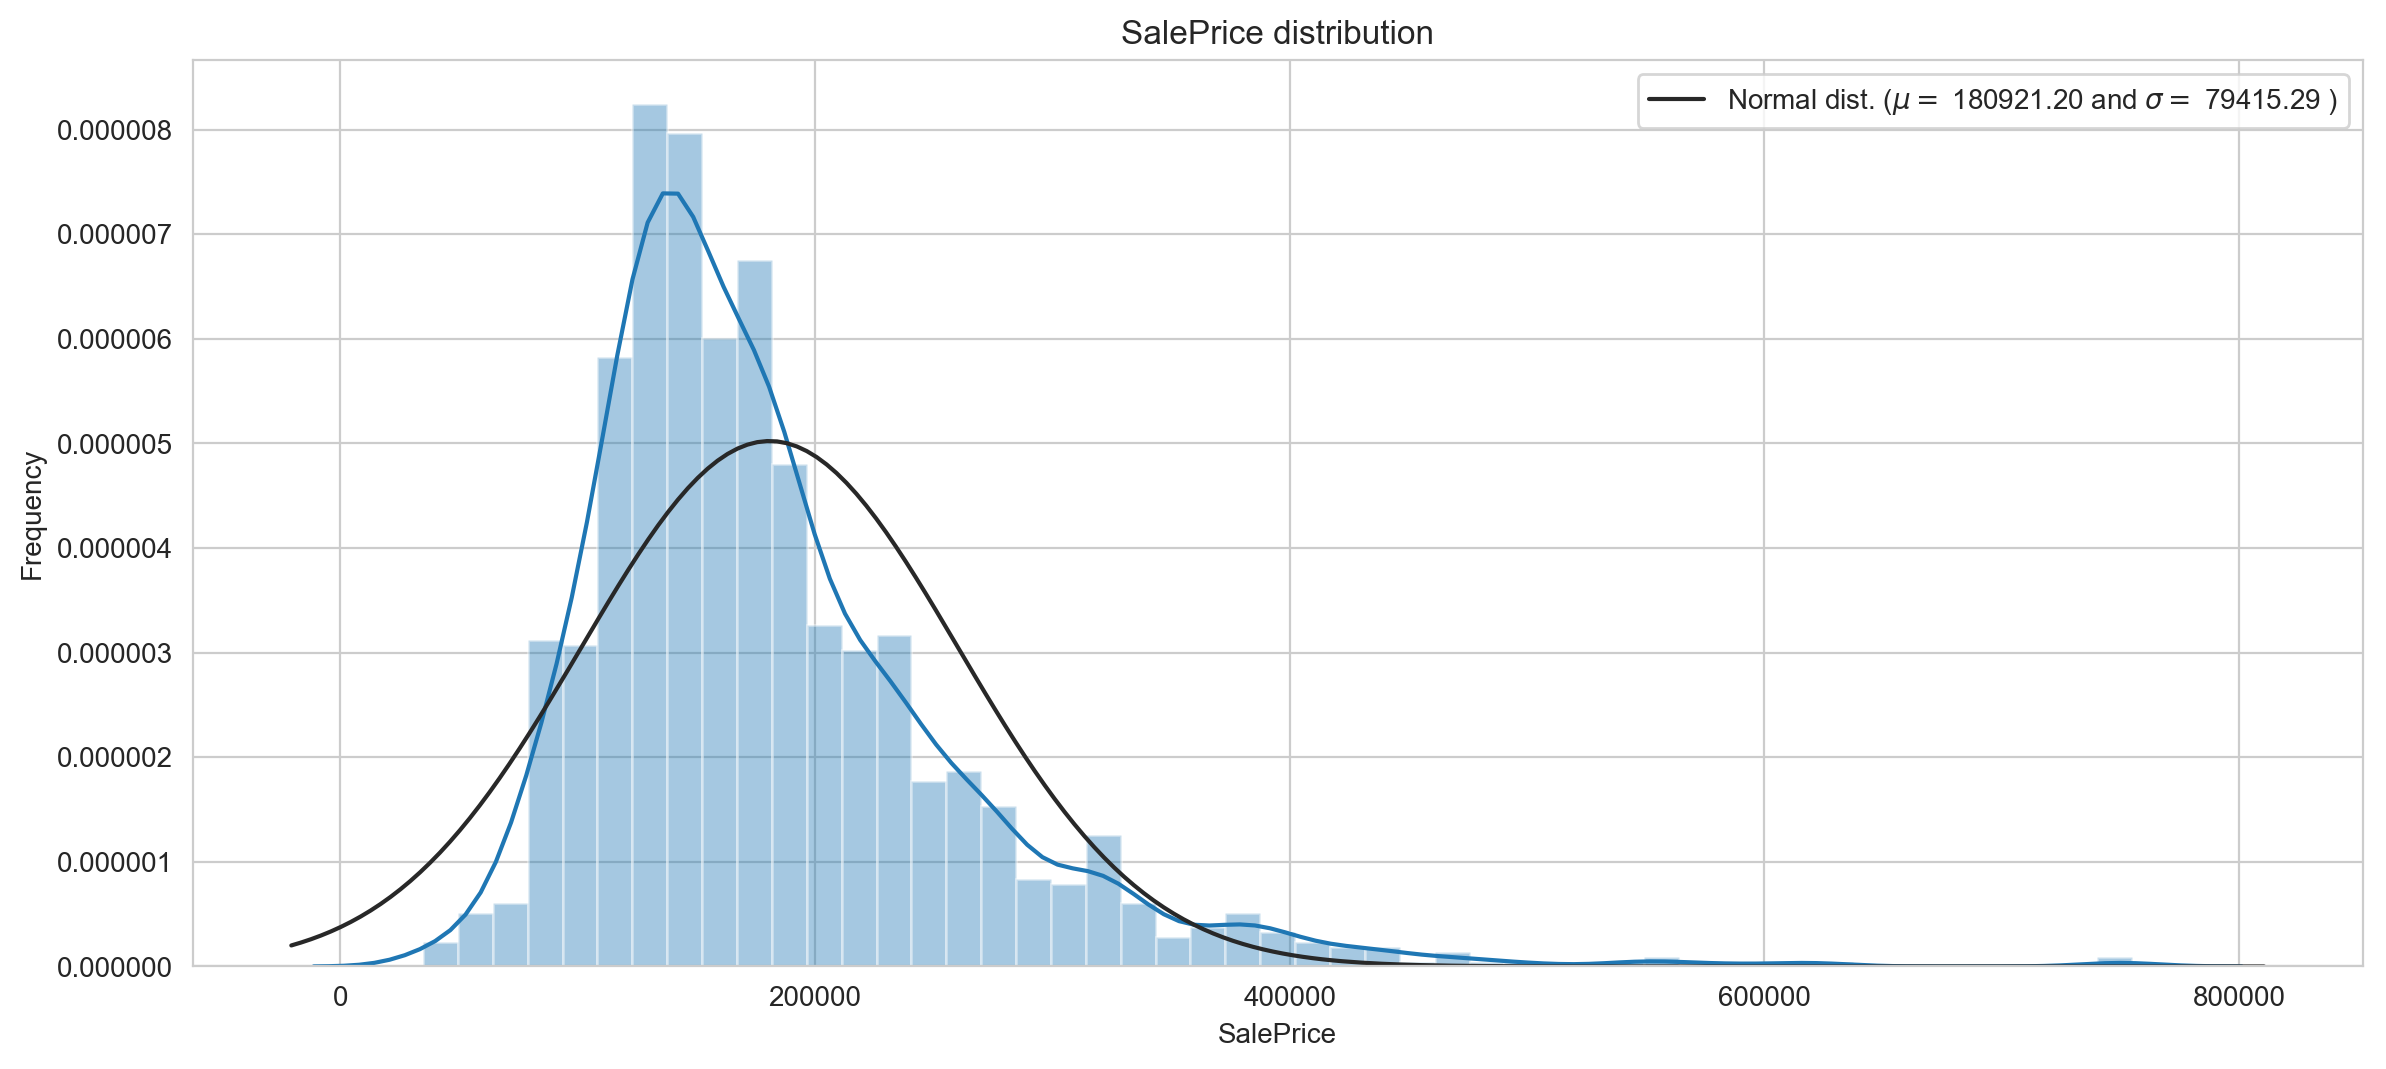

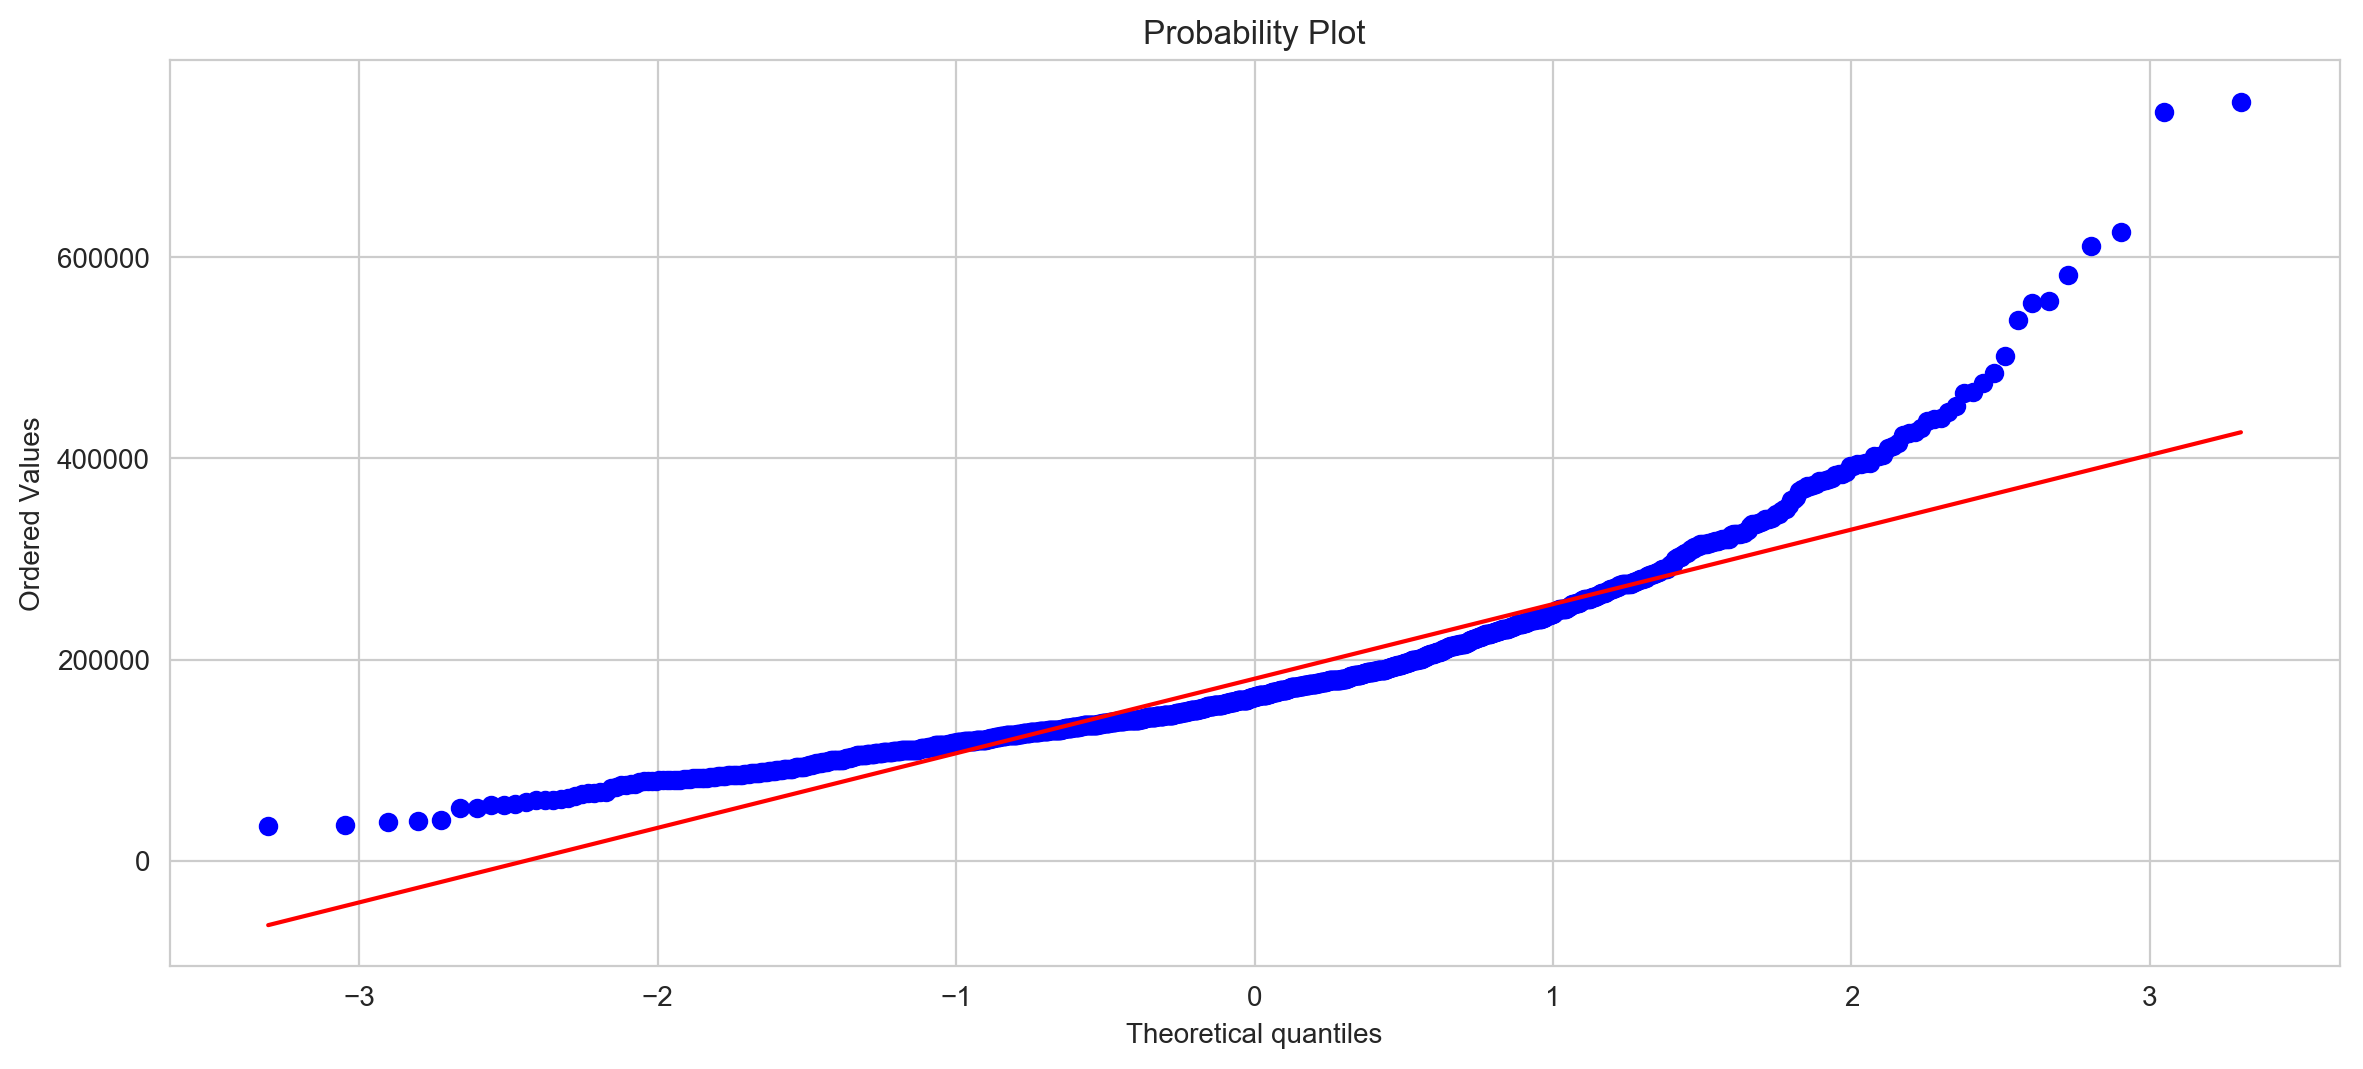

In [27]:
fig = plt.figure(figsize=(14, 6), dpi = 200)
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(14, 6), dpi = 200)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Analyzing the distribution of the sale price we can see how these values are not normally distributed. In cases like these, where the starting distribution is more similar to a Beta or a Chi2 distribution rather than a normal Distribution, sometimes can be useful to perform a logarithmic transformation of the data:

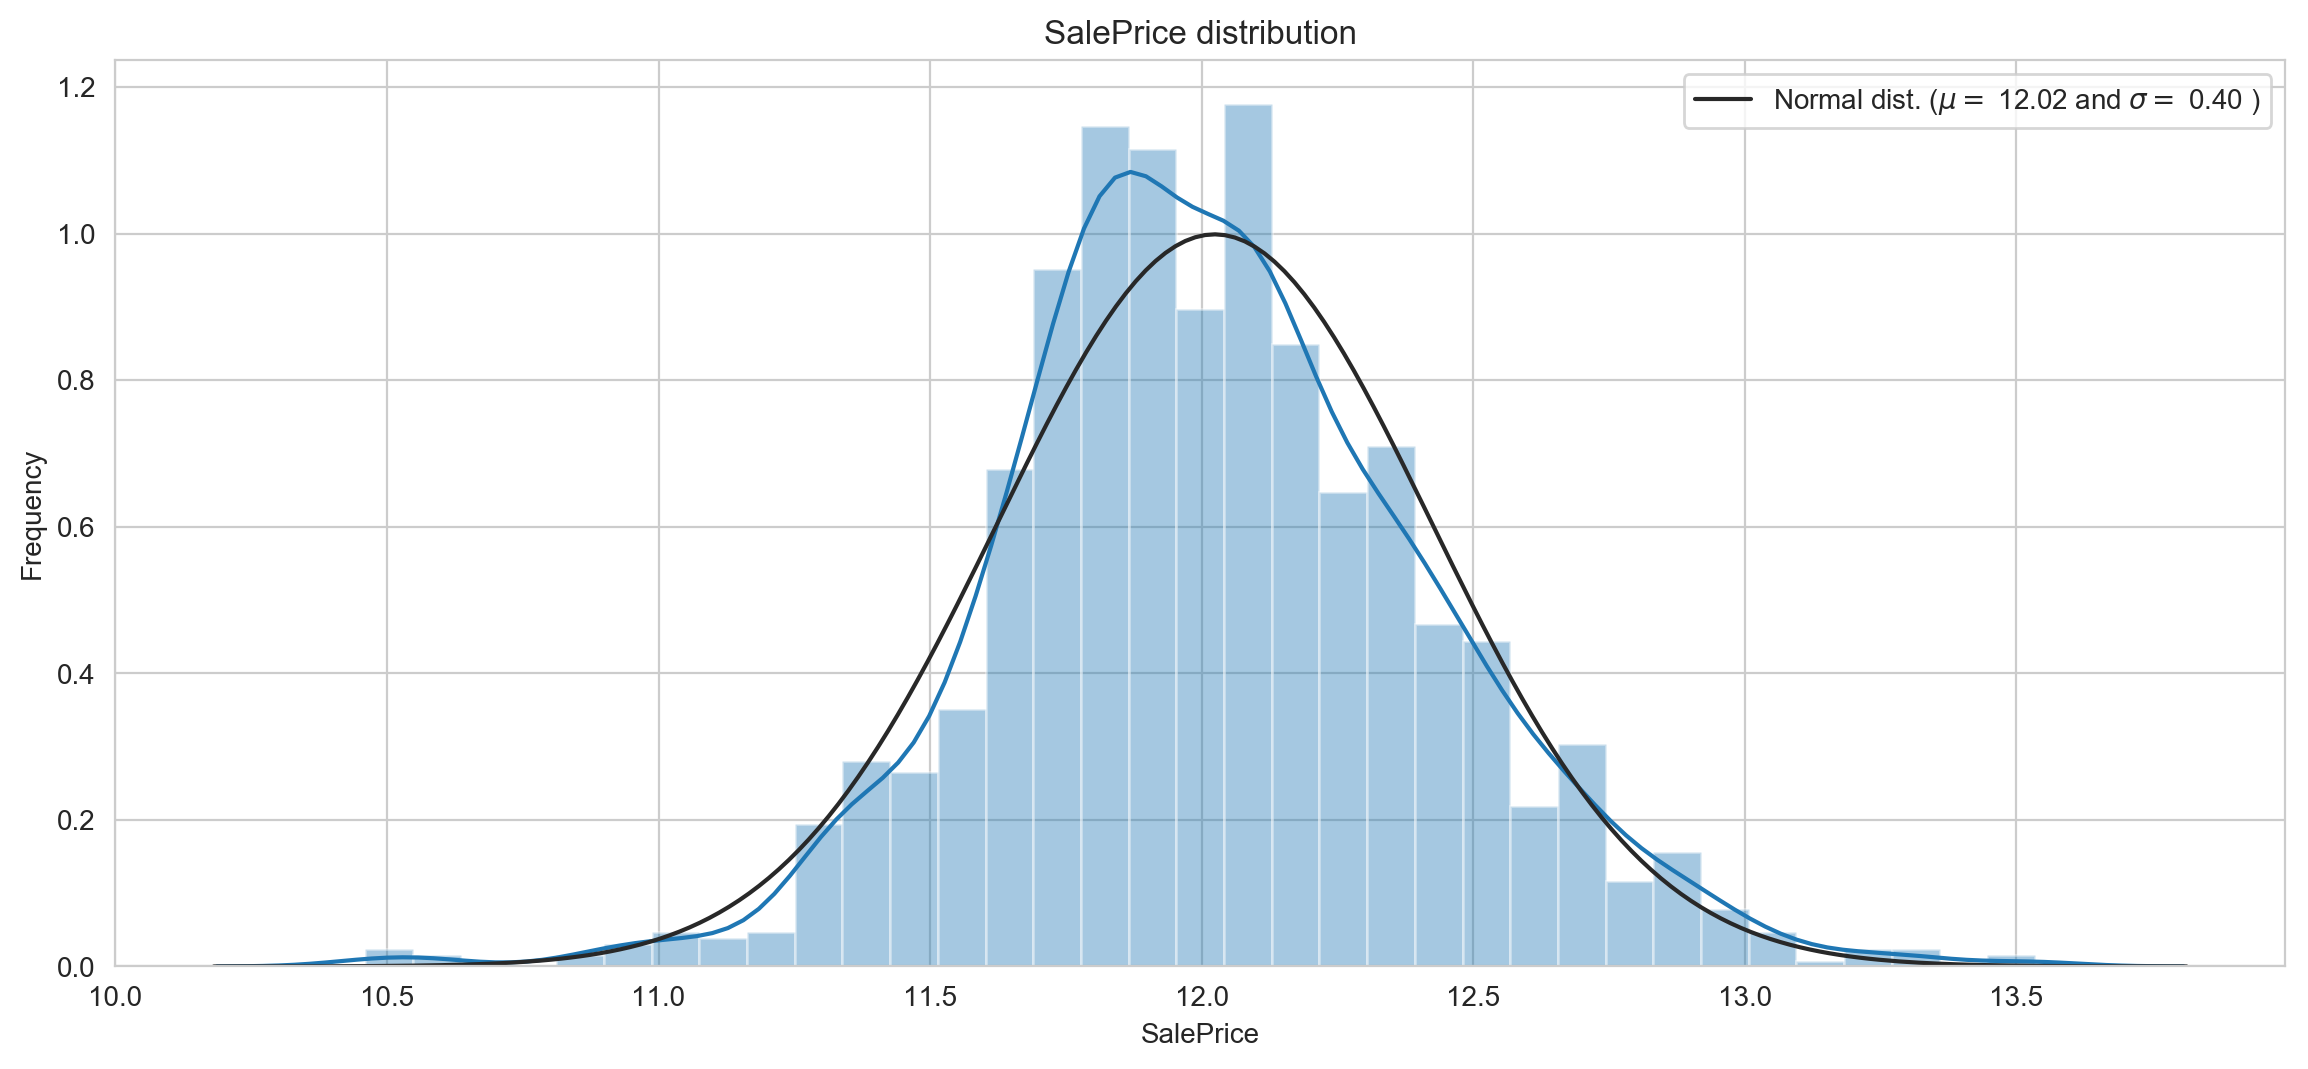

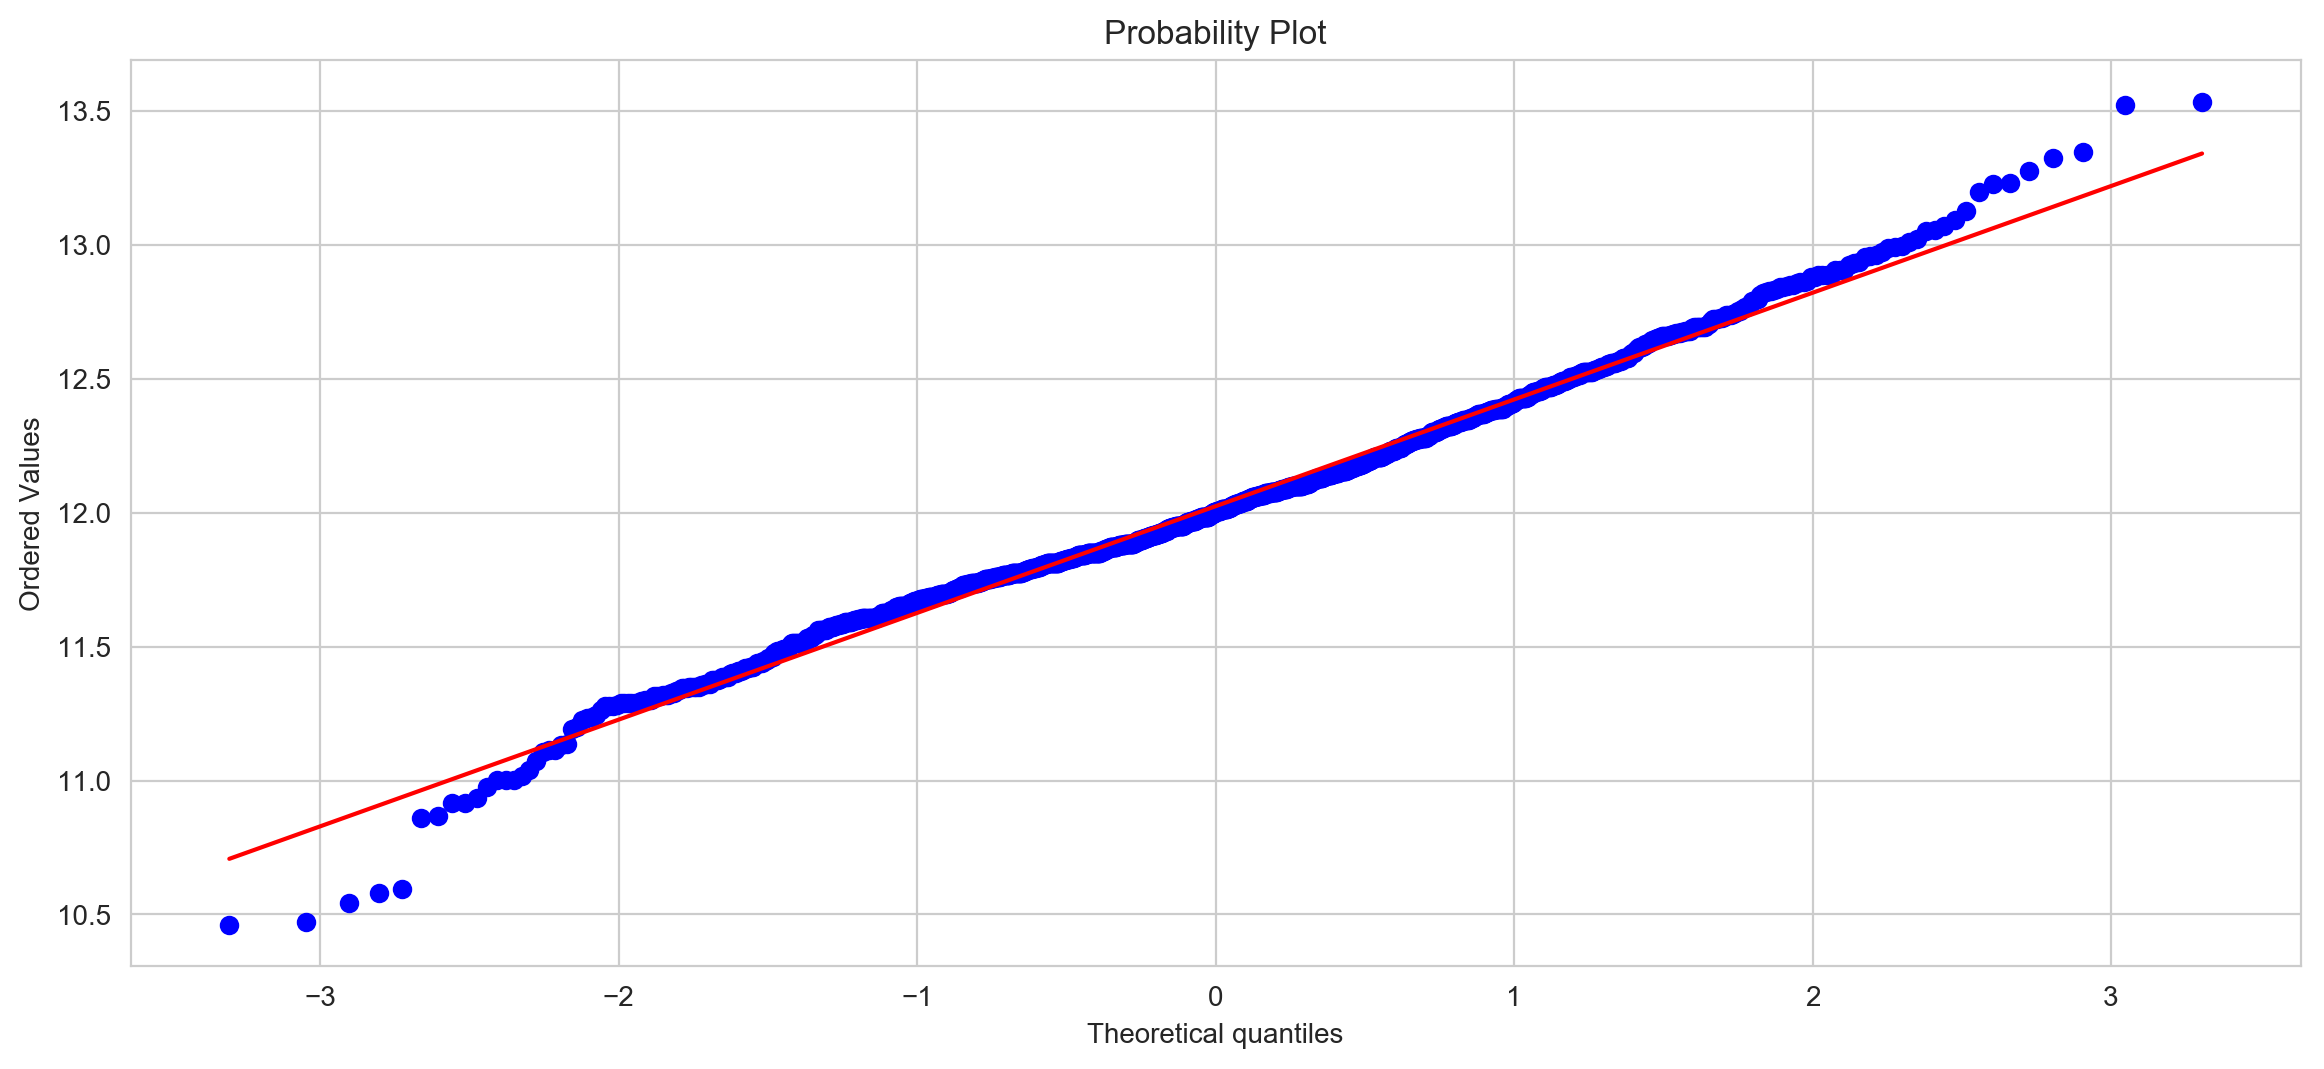

In [28]:
train["SalePrice"] = np.log1p(train["SalePrice"])

fig = plt.figure(figsize=(14, 6), dpi = 200)
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure(figsize=(14, 6), dpi = 200)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Extracting new features based on the target variable 

In [29]:
neighborhood_stats = train.groupby("Neighborhood")["SalePrice"].describe()
neighborhood_stats

,count,mean,std,min,25%,50%,75%,max
Neighborhood,,,,,,,,
Blmngtn,17.0,12.169421,0.148151,11.982279,12.066816,12.160034,12.271350,12.485831
Blueste,2.0,11.826543,0.139298,11.728045,11.777294,11.826543,11.875793,11.925042
BrDale,16.0,11.547874,0.139500,11.326608,11.418580,11.571204,11.678448,11.736077
BrkSide,58.0,11.679736,0.346318,10.579005,11.517886,11.730225,11.857755,12.317171
ClearCr,28.0,12.239905,0.238445,11.775297,12.121267,12.207326,12.397613,12.700772
CollgCr,150.0,12.163647,0.254457,11.608245,11.937872,12.191972,12.327075,12.959541
Crawfor,51.0,12.206664,0.324650,11.411457,11.978226,12.209193,12.384223,12.880294
Edwards,100.0,11.712321,0.310237,10.976799,11.527787,11.709630,11.886043,12.676079
Gilbert,79.0,12.155809,0.159985,11.856522,12.066816,12.106258,12.191885,12.841328


In [30]:
def get_neighborhood_mean(index):
    mean_price = float(neighborhood_stats[neighborhood_stats.index == index]['mean'].values)
    return mean_price

In [31]:
def get_neighborhood_std(index):
    std_price = float(neighborhood_stats[neighborhood_stats.index == index]['std'].values)
    return std_price

In [32]:
train['Neighborhood_mean'] = train['Neighborhood'].apply(get_neighborhood_mean)
train['Neighborhood_std'] = train['Neighborhood'].apply(get_neighborhood_std)
test['Neighborhood_mean'] = test['Neighborhood'].apply(get_neighborhood_mean)
test['Neighborhood_std'] = test['Neighborhood'].apply(get_neighborhood_std)

In [33]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [34]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,TotalSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,1Fam,4,3,706.0,0.0,...,WD,0,1,8,856.0,2566.0,0,2003,2003,2
1,1262,0,0,1,3,1Fam,4,1,978.0,0.0,...,WD,0,1,6,1262.0,2524.0,298,1976,1976,1
2,920,866,0,1,3,1Fam,4,2,486.0,0.0,...,WD,0,1,6,920.0,2706.0,0,2001,2002,2
3,961,756,0,1,3,1Fam,1,3,216.0,0.0,...,WD,0,1,7,756.0,2473.0,0,1915,1970,0
4,1145,1053,0,1,4,1Fam,4,0,655.0,0.0,...,WD,0,1,9,1145.0,3343.0,192,2000,2000,2


### Feature selection

In [35]:
from mltools.featureEngineering import feature_selector

In [36]:
fs = feature_selector.FeatureSelector(data = train.drop(['SalePrice'], axis=1), labels = y_train)

In [37]:
fs.identify_collinear(correlation_threshold = 0.6)

14 features with a correlation magnitude greater than 0.60.



In [38]:
fs.plot_collinear(figsize=(800, 600))

In [39]:
fs.plot_collinear(plot_all=True, figsize=(1000, 800))

In [40]:
fs.identify_single_unique()

0 features with a single unique value.



In [41]:
fs.plot_unique(figsize=(800,600), features_lim=20)

To identify the most informative features we can use the * identify_zero_importance * and * identify_low_importance * methods. These use methods based on gradient boosting machines such as lightGBM and XGBoost.

In [42]:
# Pass in the appropriate parameters
%time fs.identify_zero_importance(task = 'regression', method = 'xgboost', eval_metric = 'rmse', n_iterations = 10, early_stopping = False)

Training Gradient Boosting Model

Iteration 0

Iteration 1

Iteration 2

Iteration 3

Iteration 4

Iteration 5

Iteration 6

Iteration 7

Iteration 8

Iteration 9


64 features with zero importance after one-hot encoding.

CPU times: user 1min 8s, sys: 147 ms, total: 1min 8s
Wall time: 1min 8s


In [43]:
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

In [44]:
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 30, figsize=(800,600))

129 features required for 0.99 of cumulative importance


In [45]:
fs.identify_low_importance(cumulative_importance = 0.99)

128 features required for cumulative importance of 0.99 after one hot encoding.
95 features do not contribute to cumulative importance of 0.99.



### Feature selection using GA

In [46]:
ga_params = {'cv':5,
            'verbose':1,
            'scoring':"neg_mean_squared_error",
            'n_population' : 20,
            'crossover_proba' : 0.5,
            'mutation_proba' : 0.2,
            'n_generations' : 5,
            'crossover_independent_proba' : 0.5,
            'mutation_independent_proba' : 0.05,
            'tournament_size' : 3,
            'caching' : True,
            'n_jobs' : -1}

In [47]:
%time fs.ga_selector(task='regression', method = 'xgboost', ga_params = ga_params)

Selecting features with genetic algorithm.
gen	nevals	avg                            	std                            	min                              	max                            
0  	20    	[-1.9811743e-02  1.1265000e+02]	[2.66564775e-03 6.95179833e+00]	[-2.66293318e-02  1.01000000e+02]	[-1.5537434e-02  1.2400000e+02]
1  	9     	[-1.74497729e-02  1.14550000e+02]	[1.70686385e-03 4.75893896e+00]	[-2.09850023e-02  1.05000000e+02]	[-1.5695368e-02  1.2500000e+02]
2  	15    	[-1.6343862e-02  1.1700000e+02]  	[5.54310467e-04 5.81377674e+00]	[-1.76953976e-02  1.03000000e+02]	[-1.57081516e-02  1.27000000e+02]
3  	15    	[-1.5892453e-02  1.1965000e+02]  	[5.08650593e-04 5.23712708e+00]	[-1.67385686e-02  1.13000000e+02]	[-1.47349224e-02  1.26000000e+02]
4  	20    	[-1.5782146e-02  1.2255000e+02]  	[8.60580976e-04 4.52189120e+00]	[-1.82269857e-02  1.09000000e+02]	[-1.43848087e-02  1.28000000e+02]
5  	15    	[-1.53568884e-02  1.23900000e+02]	[4.62108363e-04 3.64554523e+00]	[-1.66657799e-02  1.

In [48]:
# Remove the features(returns a df)
data_clean = fs.remove(methods = ['ga_selection'], keep_one_hot=False)

Removed 190 features including one-hot features.


In [49]:
data_clean.head()

,1stFlrSF,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtQual,Condition1,...,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,YearBuilt,YearRemodAdd,YrSold,TotalSF,Neighborhood_mean
0,856,3,1Fam,4,3,706.0,0.0,2,2,Norm,...,CompShg,Gable,Normal,WD,1,2003,2003,2,2566.0,12.163647
1,1262,3,1Fam,4,1,978.0,0.0,0,2,Feedr,...,CompShg,Gable,Normal,WD,1,1976,1976,1,2524.0,12.344180
2,920,3,1Fam,4,2,486.0,0.0,2,2,Norm,...,CompShg,Gable,Normal,WD,1,2001,2002,2,2706.0,12.163647
3,961,3,1Fam,1,3,216.0,0.0,0,4,Norm,...,CompShg,Gable,Abnorml,WD,1,1915,1970,0,2473.0,12.206664
4,1145,4,1Fam,4,0,655.0,0.0,2,2,Norm,...,CompShg,Gable,Normal,WD,1,2000,2000,2,3343.0,12.676003


In [50]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 223)


In [51]:
data_clean = pd.get_dummies(data_clean)
print(data_clean.shape)

(1460, 195)


In [52]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [53]:
train_clean = data_clean
test_clean = test[[col for col in data_clean.columns]]

In [54]:
print(train.shape, test.shape)
print(train_clean.shape, test_clean.shape)

(1460, 223) (1459, 223)
(1460, 195) (1459, 195)


In [55]:
from sklearn.preprocessing import RobustScaler

In [56]:
#feature scaling
train_scaled = RobustScaler().fit_transform(train)

### Modelling 

In [58]:
from mltools.evaluateModels import CrossValidation

The CrossValidation class takes in input a list of models to be test and a list of score metrics for the evaluation and return the best model with the best configuration of parameters.

The *param_file.txt* contain:
- models to test and their params;
- training strategy (GridSearch, RandomSearch, BayesianOptimization);
- loss function to optimize;

**Note:** for better results in bayesian optimizaton it's necessary to use a number of iterations >2000

In [59]:
cv = CrossValidation(
    models=['RandomForest_regressor', 'XGBoost_regressor'], 
    scores = ["rmse", "mae"],
    params_file = "./param_file.txt") # Configuration file

In [62]:
res, model = cv.fit(train_clean, y_train, plot_iteration_results=True)

Model: RandomForest_regressor
Searching the best RandomForest_regressor with bayesian optimization cv...


/Users/Gabriele/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Iteration: 100, Score: 0.1641.
Iteration: 200, Score: 0.164.
Iteration: 300, Score: 0.1633.
Iteration: 400, Score: 0.1624.
Iteration: 500, Score: 0.1638.
Iteration: 600, Score: 0.1617.
Iteration: 700, Score: 0.162.
Iteration: 800, Score: 0.1639.
Iteration: 900, Score: 0.1621.
Iteration: 1000, Score: 0.1611.



Best_estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=19,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=17, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Best_scores: 0.1611006540820707
Evaluate the best model configuration with a new cross validation...

Model: XGBoost_regressor
Not possible to plot iteration results for random_search
Searching the best XGBoost_regressor with random search cv...

Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5198914668059879, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=14, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.0947892586517769,
    

In [63]:
res

,RandomForest_regressor,XGBoost_regressor
computation_total,0.275815,9.76681
test_rmse_mean,0.171997,0.121008
test_rmse_sd,0.0153629,0.0146316
test_rmse_ci_95%,"[0.1683, 0.1757]","[0.1175, 0.1245]"
test_rmse_ci_99%,"[0.1667, 0.1773]","[0.116, 0.126]"
train_rmse_mean,0.0781133,0.0220172
train_rmse_sd,0.0032196,0.000243952
train_rmse_ci_95%,"[0.0773, 0.0789]","[0.022, 0.0221]"
train_rmse_ci_99%,"[0.077, 0.0792]","[0.0219, 0.0221]"
test_mae_mean,0.114448,0.0836829


In [63]:
res_train_complete, model_train_complete = cv.fit_cv(train, y_train)

Model: RandomForest_regressor
Searching the best RandomForest_regressor with bayesian optimization cv...
Iteration: 100, Score: 0.1599.
Iteration: 200, Score: 0.1598.
Iteration: 300, Score: 0.1606.
Iteration: 400, Score: 0.1608.
Iteration: 500, Score: 0.1595.
Iteration: 600, Score: 0.1602.
Iteration: 700, Score: 0.1595.
Iteration: 800, Score: 0.1597.
Iteration: 900, Score: 0.1595.
Iteration: 1000, Score: 0.1569.

Best_estimator: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=17, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Best_scores: 0.15688108414300664
Evaluate the best model configuration with a new cross validation...

Model: XGBoost_regressor
Searching the best XGBoost_regressor with random search cv...


In [64]:
res_train_complete

Loading BokehJS ...

,RandomForest_regressor,XGBoost_regressor
computation_total,0.48332,19.5329
test_rmse_mean,0.167681,0.120065
test_rmse_sd,0.0178167,0.0155274
test_rmse_ci_95%,"[0.1542, 0.1811]","[0.1084, 0.1318]"
test_rmse_ci_99%,"[0.1484, 0.187]","[0.1032, 0.1369]"
train_rmse_mean,0.0782203,0.053571
train_rmse_sd,0.0023524,0.000554653
train_rmse_ci_95%,"[0.0764, 0.08]","[0.0532, 0.054]"
train_rmse_ci_99%,"[0.0757, 0.0808]","[0.053, 0.0542]"
test_mae_mean,0.11487,0.0821228


### Stacking and Bayesian Optimization

Now proceed to create a stack with the classifiers used in the previous step. In this case we use only one meta-learner, in particular an elastic net. Note that to create more levels of meta-classifiers it is sufficient to repeat the process mentioned below several times. The stacking code is contained in the stackingEnsemble module of mltools.

In [64]:
from mltools.stackingEnsemble import StackingModels

In [65]:
model_ensemble_1 = [model for key, model in model.items()]
model_ensemble_2 = [model for key, model in model_train_complete.items()]

NameError: name 'model_train_complete' is not defined

At this point we create an instance of the stacking model passing the models, the training and the test set (necessary to have the finals features). Note that in this case the data must be passed in the form of a numpy array. The method perform a 10-fold cross validation and returns a tuple containing at index 0 the dataframe with the predictions for each example of the training set and, at index 1, the predictions on the test set.

In [ ]:
stack_1 = StackingModels(algorithms=model_ensemble_1)
stack_2 = StackingModels(algorithms=model_ensemble_2)

In [69]:
out_1 = stack_1.fit(train_clean.values, y_train,  test_clean.values)

Fitting RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=17, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Fitting XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=0.634016555319344, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=13, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.4817093470245457,
       reg_lambda=0.9537638800761856, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [70]:
out_2 = stack_2.fit(train.values, y_train,  test.values)

Fitting RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=17, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Fitting XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=0.5719542805805264, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=35, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.46562224595760904,
       reg_lambda=0.6950502571233805, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [71]:
out_1[0].head()

,RandomForestRegressor,XGBRegressor
0,12.248399,12.265537
1,12.043826,12.115989
2,12.337347,12.255141
3,11.986304,12.122353
4,12.612278,12.605105


In [72]:
meta_train = pd.concat([out_1[0], out_2[0]], axis=1)

In [73]:
meta_train.head()

,RandomForestRegressor,XGBRegressor,RandomForestRegressor,XGBRegressor
0,12.248399,12.265537,12.221779,12.252767
1,12.043826,12.115989,12.073613,12.137032
2,12.337347,12.255141,12.304573,12.264809
3,11.986304,12.122353,12.108660,12.146183
4,12.612278,12.605105,12.506596,12.611878


In [77]:
cv_meta_learner = CrossValidation(
    models='XGBoost_regressor', # Lista dei modelli da testare
    scores = "rmse", # Metriche di confronto che vogliamo farci restituire
    params_file = "./param_file.txt") # File di configurazione esterno

In [78]:
res_stacking, model = cv_meta_learner.fit_cv(meta_train.values, y_train)

Model: XGBoost_regressor
Searching the best XGBoost_regressor with random search cv...

Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8989360925625752, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.5224972599596899,
       reg_lambda=0.31227533694163967, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Best_scores: -0.015547723642281222
Evaluate the best model configuration with a new cross validation...

Finish


In [79]:
res_stacking

,XGBoost_regressor
computation_total,0.324847
test_rmse_mean,0.123668
test_rmse_sd,0.0159391
test_rmse_ci_95%,"[0.1116, 0.1357]"
test_rmse_ci_99%,"[0.1064, 0.1409]"
train_rmse_mean,0.108288
train_rmse_sd,0.00171794
train_rmse_ci_95%,"[0.107, 0.1096]"
train_rmse_ci_99%,"[0.1064, 0.1101]"
